<div align="center" style="font-size: 2rem">

<img heoght="300px" src="https://cta-observatory.github.io/ctapipe/_images/ctapipe_logo.png" alt="ctapipe"/>


<p style="text-align: center;">LST Analysis Bootcamp</p>

<p style="text-align: center">Padova, 26.11.2018</p>

<p style="text-align: center">Maximilian Nöthe (@maxnoe) & Kai A. Brügge (@mackaiver)</p>

</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14

plt.rcParams['figure.figsize']

[12.0, 8.0]

In [3]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# General Information


## Design

* ctapipe is built upon the Scientific Python Stack, core dependencies are
  * numpy
  * scipy
  * astropy
  


## Developement

* ctapipe is developed as Open Source Software (Currently under MIT License) at <https://github.com/cta-observatory/ctapipe>

* We use the "Github-Workflow": 
  * Few people (e.g. @kosack, @mackaiver) have write access to the main repository
  * Contributors fork the main repository and work on branches
  * Pull Requests are merged after Code Review and automatic execution of the test suite

* Early developement stage ⇒ backwards-incompatible API changes might and will happen 

* Many open design questions ⇒ Core Developer Meeting in the second week of December in Dortmund

## What's there?

* Reading simtel simulation files
* Simple calibration, cleaning and feature extraction functions
* Camera and Array plotting
* Coordinate frames and transformations 
* Stereo-reconstruction using line intersections
  
## What's still missing?

* Easy to use input/output of analysis results to standard data formats (e.g. FITS, hdf5)
* Easy to use "analysis builder"
* A "Standard Analysis"
* Good integration with machine learning techniques
* IRF calculation 
* Defining APIs for IO, instrument description access etc.
* Most code only tested on HESSIO simulations
* Documentation, e.g. formal definitions of coordinate frames 
 
## What can you do?

* Report issues
  * Hard to get started? Tell us where you are stuck
  * Tell user stories
  * Missing features

* Start contributing
  * ctapipe needs more workpower
  * Implement new reconstruction features


# A simple hillas analysis

## Reading in simtel files

In [4]:
from ctapipe.io import EventSourceFactory
from ctapipe.utils.datasets import get_dataset_path

input_url = get_dataset_path('gamma_test_large.simtel.gz')

# The EventSourceFactory automatically detects what kind of file we are giving it,
# if already supported by ctapipe
event_source = EventSourceFactory.produce(input_url=input_url, max_events=9)

print(type(event_source))

<class 'ctapipe.io.hessioeventsource.HESSIOEventSource'>


In [5]:
for event in event_source:
    print(f'Id: {event.count}', f'E = {event.mc.energy:1.3f}', f'Telescopes: {len(event.r0.tel)}', sep=', ')

Id: 0, E = 0.571 TeV, Telescopes: 4
Id: 1, E = 1.864 TeV, Telescopes: 9
Id: 2, E = 1.864 TeV, Telescopes: 4
Id: 3, E = 1.864 TeV, Telescopes: 17
Id: 4, E = 1.864 TeV, Telescopes: 2
Id: 5, E = 0.464 TeV, Telescopes: 7
Id: 6, E = 0.017 TeV, Telescopes: 2
Id: 7, E = 76.426 TeV, Telescopes: 4
Id: 8, E = 76.426 TeV, Telescopes: 16


Each event is a `DataContainer` holding several `Field`s of data, which can be containers or just numbers.
Let's look a one event:

In [6]:
event

ctapipe.io.containers.DataContainer:
                          r0.*: Raw Data
                          r1.*: R1 Calibrated Data
                         dl0.*: DL0 Data Volume Reduced Data
                         dl1.*: DL1 Calibrated image
                         dl2.*: Reconstructed Shower Information
                          mc.*: Monte-Carlo data
                    mcheader.*: Monte-Carlo run header data
                        trig.*: central trigger information
                         count: number of events processed
                        inst.*: instrumental information (deprecated
                   pointing[*]: Telescope pointing positions

In [7]:
event.inst.subarray.camera_types

['FlashCam', 'LSTCam', 'ASTRICam']

In [8]:
len(event.r0.tel), len(event.r1.tel)

(16, 0)

## Data calibration

As we saw, the data container only contains raw data (only the `r0` containers are filled)

So we use the `CameraCalibrator` factory to calibrate the event.

In [9]:
from ctapipe.calib import CameraCalibrator

calibrator = CameraCalibrator(
    eventsource=event_source,
)

In [10]:
calibrator.r1

In [11]:
calibrator.calibrate(event)

## Event displays

Let's use ctapipe's plotting facilities to plot the telescope images

In [12]:
event.dl1.tel.keys()

dict_keys([32, 33, 65, 35, 41, 10, 45, 15, 17, 18, 22, 23, 57, 27, 29, 31])

In [13]:
tel_id = 22


In [14]:
camera = event.inst.subarray.tel[tel_id].camera
dl1 = event.dl1.tel[tel_id]

camera, dl1

(CameraGeometry(cam_id='FlashCam', pix_type='hexagonal', npix=1764, cam_rot=0.0 deg, pix_rot=30.0 deg),
 ctapipe.io.containers.DL1CameraContainer:
                          image: np array of camera image, after waveform
                                 integration (N_pix)
                   gain_channel: boolean numpy array of which gain channel was
                                 used for each pixel in the image
              extracted_samples: numpy array of bools indicating which samples
                                 were included in the charge extraction as a
                                 result of the charge extractor chosen.
                                 Shape=(nchan, npix, nsamples).
                        peakpos: numpy array containing position of the peak as
                                 determined by the peak-finding algorithm for
                                 each pixel
                        cleaned: numpy array containing the waveform after
            

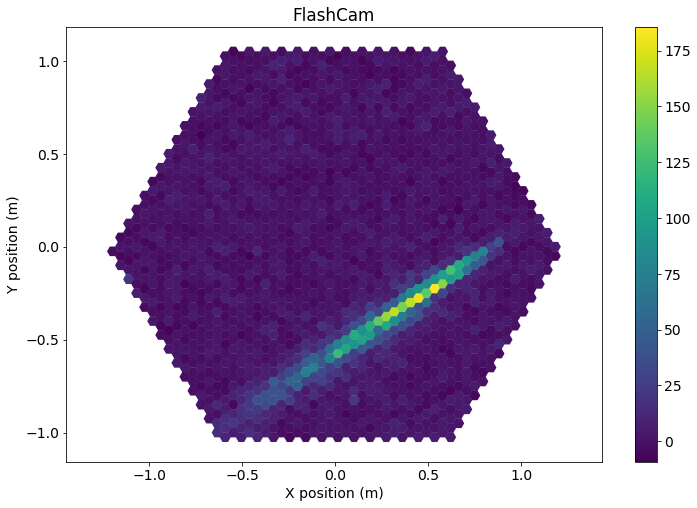

In [15]:
from ctapipe.visualization import CameraDisplay

display = CameraDisplay(camera)

# right now, there might be one image per gain channel.
# This will change as soon as 
display.image = dl1.image[0]
display.add_colorbar()

## Image Cleaning

In [16]:
from ctapipe.image.cleaning import tailcuts_clean

In [17]:
# unoptimized cleaning levels, copied from 
# https://github.com/tudo-astroparticlephysics/cta_preprocessing
cleaning_level = {
    'ASTRICam': (5, 7, 2),  # (5, 10)?
    'LSTCam': (3.5, 7.5, 2),  # ?? (3, 6) for Abelardo...
    'FlashCam': (4, 8, 2),  # there is some scaling missing?
}

In [18]:
boundary, picture, min_neighbors = cleaning_level[camera.cam_id]

clean = tailcuts_clean(
    camera, 
    dl1.image[0],
    boundary_thresh=boundary,
    picture_thresh=picture,
    min_number_picture_neighbors=min_neighbors
)

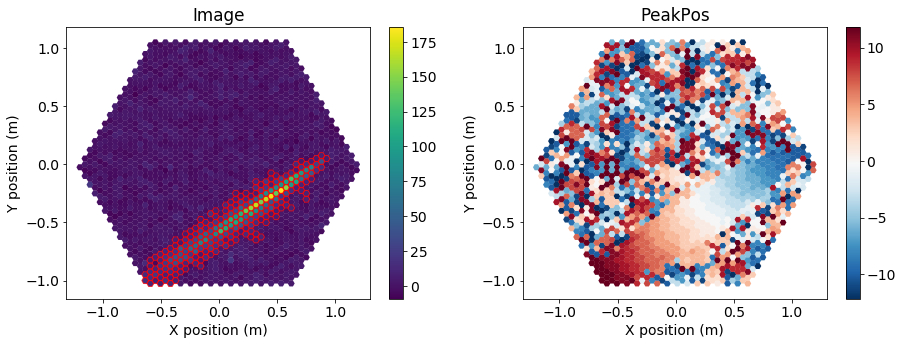

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

d1 = CameraDisplay(camera, ax=ax1)
d2 = CameraDisplay(camera, ax=ax2)

ax1.set_title('Image')
d1.image = dl1.image[0]
d1.add_colorbar(ax=ax1)

ax2.set_title('PeakPos')
d2.image = dl1.peakpos[0] - np.average(dl1.peakpos[0], weights=dl1.image[0])
d2.cmap = 'RdBu_r'
d2.add_colorbar(ax=ax2)

d1.highlight_pixels(clean, color='red', linewidth=1)

## Image Parameters

In [20]:
from ctapipe.image import hillas_parameters, leakage, concentration
from ctapipe.image.timing_parameters import timing_parameters
from ctapipe.image.cleaning import number_of_islands

In [21]:
hillas = hillas_parameters(camera[clean], dl1.image[0][clean])

print(hillas)

{'intensity': 8022.420040219512,
 'kurtosis': 2.3774879349559748,
 'length': <Quantity 0.416376 m>,
 'phi': <Angle -1.08918488 rad>,
 'psi': <Angle -2.54790228 rad>,
 'r': <Quantity 0.4774354 m>,
 'skewness': 0.33831006187240015,
 'width': <Quantity 0.05629007 m>,
 'x': <Quantity 0.22115186 m>,
 'y': <Quantity -0.42312695 m>}


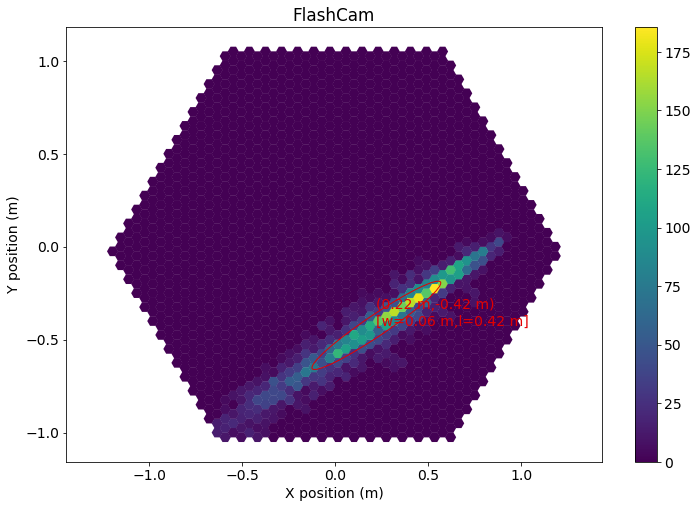

In [22]:
display = CameraDisplay(camera)

# set "unclean" pixels to 0
cleaned = dl1.image[0].copy()
cleaned[~clean] = 0.0

display.image = cleaned
display.add_colorbar()


display.overlay_moments(hillas, color='xkcd:red')

In [23]:
timing = timing_parameters(
    camera[clean],
    dl1.image[0][clean],
    dl1.peakpos[0][clean],
    hillas,
)

print(timing)

{'intercept': 12.286855933683663, 'slope': <Quantity 11.87359303 1 / m>}


In [24]:
l = leakage(camera, dl1.image[0], clean)
print(l)

{'leakage1_intensity': 0.010986655595495536,
 'leakage1_pixel': 0.0045351473922902496,
 'leakage2_intensity': 0.022472706118755816,
 'leakage2_pixel': 0.008503401360544218}


In [25]:
n_islands, island_id = number_of_islands(camera, clean)

print(n_islands)

1


In [26]:
conc = concentration(camera, dl1.image[0], hillas)
print(conc)

{'concentration_cog': 0.038537618168664,
 'concentration_core': 0.4124183299059514,
 'concentration_pixel': 0.023142858700747324}


## Putting it all together / Stereo reconstruction

In [29]:
import astropy.units as u

from ctapipe.io import EventSourceFactory
from ctapipe.utils.datasets import get_dataset_path

from ctapipe.calib import CameraCalibrator

from ctapipe.image.cleaning import tailcuts_clean, number_of_islands

from ctapipe.reco import HillasReconstructor


# unoptimized cleaning levels, copied from 
# https://github.com/tudo-astroparticlephysics/cta_preprocessing
cleaning_level = {
    'ASTRICam': (5, 7, 2),  # (5, 10)?
    'LSTCam': (3.5, 7.5, 2),  # ?? (3, 6) for Abelardo...
    'FlashCam': (4, 8, 2),  # there is some scaling missing?
}


input_url = get_dataset_path('gamma_test_large.simtel.gz')
event_source = EventSourceFactory.produce(input_url=input_url, max_events=9)


calibrator = CameraCalibrator(
    eventsource=event_source,
)

reco = HillasReconstructor()

for event in event_source:
    print(f'Id: {event.count}', f'E = {event.mc.energy:1.3f}', f'Telescopes: {len(event.r0.tel)}', sep=', ')
    
    calibrator.calibrate(event)
    
    # mapping of telescope_id to parameters for stereo reconstruction
    hillas_containers = {}
    pointing_azimuth = {}
    pointing_altitude = {}
    time_gradients = {}
    
    for telescope_id, dl1 in event.dl1.tel.items():        
        camera = event.inst.subarray.tels[telescope_id].camera
        image = dl1.image[0]
        peakpos = dl1.peakpos[0]
        
        boundary, picture, min_neighbors = cleaning_level[camera.cam_id]

        clean = tailcuts_clean(
            camera, 
            image,
            boundary_thresh=boundary,
            picture_thresh=picture,
            min_number_picture_neighbors=min_neighbors
        )
        
        hillas_c = hillas_parameters(camera[clean], image[clean])
        leakage_c = leakage(camera, image, clean)
        n_islands, island_ids = number_of_islands(camera, clean)
        
        timing_c = timing_parameters(camera[clean], image[clean], peakpos[clean], hillas_c)
        
        hillas_containers[telescope_id] = hillas_c
        
        # ssts have no timing in prod4, so we'll use the skewness
        time_gradients[telescope_id] = timing_c.slope.value if camera.cam_id != 'ASTRICam' else hillas_c.skewness
        
        pointing_azimuth[telescope_id] = event.mc.tel[telescope_id].azimuth_raw * u.rad
        pointing_altitude[telescope_id] = event.mc.tel[telescope_id].altitude_raw * u.rad
        
        
    stereo = reco.predict(
        hillas_containers, event.inst, pointing_altitude, pointing_azimuth
    )
    
    print(f'  Alt: {stereo.alt.deg:.2f}°')
    print(f'  Az: {stereo.az.deg:.2f}°')
    print(f'  Hmax: {stereo.h_max:.0f}')
    print(f'  CoreX: {stereo.core_x:.1f}')
    print(f'  CoreY: {stereo.core_y:.1f}')



Id: 0, E = 0.571 TeV, Telescopes: 4
  Alt: 66.69°
  Az: -7.61°
  Hmax: 7764 m
  CoreX: 550.9 m
  CoreY: -27.0 m
Id: 1, E = 1.864 TeV, Telescopes: 9
  Alt: 68.29°
  Az: -353.25°
  Hmax: 7849 m
  CoreX: 153.1 m
  CoreY: -712.0 m
Id: 2, E = 1.864 TeV, Telescopes: 4
  Alt: 68.52°
  Az: -354.25°
  Hmax: 7122 m
  CoreX: -231.9 m
  CoreY: -841.2 m
Id: 3, E = 1.864 TeV, Telescopes: 17
  Alt: 68.51°
  Az: -353.48°
  Hmax: 6916 m
  CoreX: 223.8 m
  CoreY: -198.8 m
Id: 4, E = 1.864 TeV, Telescopes: 2
  Alt: 68.66°
  Az: -353.31°
  Hmax: 6310 m
  CoreX: -936.1 m
  CoreY: 187.1 m
Id: 5, E = 0.464 TeV, Telescopes: 7
  Alt: 71.91°
  Az: -1.05°
  Hmax: 8488 m
  CoreX: -377.5 m
  CoreY: 360.3 m
Id: 6, E = 0.017 TeV, Telescopes: 2
  Alt: 70.47°
  Az: -359.53°
  Hmax: 10853 m
  CoreX: -258.4 m
  CoreY: -364.3 m
Id: 7, E = 76.426 TeV, Telescopes: 4
  Alt: 74.95°
  Az: -354.31°
  Hmax: 6520 m
  CoreX: -478.2 m
  CoreY: -1420.7 m
Id: 8, E = 76.426 TeV, Telescopes: 16
  Alt: 75.18°
  Az: -354.19°
  Hmax: 575

### ArrayDisplay


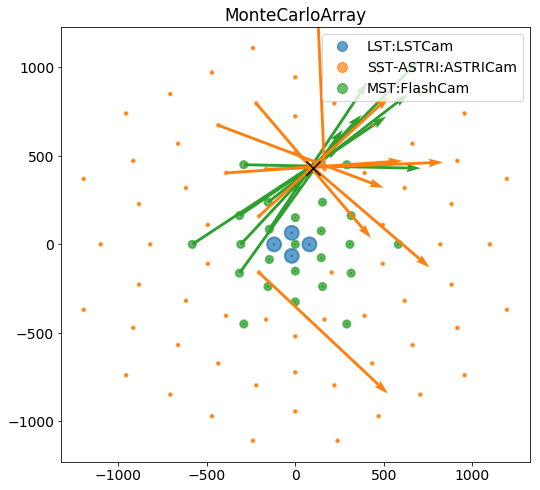

In [30]:
from ctapipe.visualization import ArrayDisplay


angle_offset = event.mcheader.run_array_direction[0]

disp = ArrayDisplay(event.inst.subarray)

disp.set_vector_hillas(hillas_containers, time_gradient=time_gradients, angle_offset=angle_offset, length=1e3)
plt.scatter(event.mc.core_x, event.mc.core_y, s=200, c='k', marker='x', label='True Impact',)